# Analyzing User Behavior and Algorithm Performance in a Sparse Movie Recommendation System

# PART 1 - Import Libraries and Get Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Downgrade NumPy
!pip install numpy==1.24.4

# Step 2: Uninstall scikit-surprise if it's already there
!pip uninstall -y scikit-surprise

# Step 3: Reinstall from source (forces compile with current NumPy)
!pip install cython
!pip install scikit-surprise --no-binary scikit-surprise


Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, NMF, KNNWithZScore, KNNBasic, KNNWithMeans, KNNBaseline, NormalPredictor
from surprise.model_selection import cross_validate, GridSearchCV

In [2]:
ratings = pd.read_csv("/content/drive/MyDrive/analys_customer/MovieLens-Ratings.csv")
ratings = ratings.sample(n=100_000, random_state=42).reset_index(drop=True)

The original MovieLens dataset contains **over 27 million ratings**, which is ideal for industry-scale research but can be computationally expensive for classroom assignments or personal machines.

We chose to use a **random sample of 100,000 ratings** for the following reasons:

- **Efficiency**: Training and cross-validating recommender system models (especially matrix factorization methods) on millions of entries requires significant processing power and memory. A 100k sample allows us to experiment and iterate quickly.
  
- **Exploratory Analysis**: For EDA, trend discovery, and initial modeling, 100k is large enough to reveal **meaningful patterns and distributional properties** (e.g., rating skew, sparsity, popularity bias).

- **Fair Trade-off**: 100k records provide a **manageable size** for deep analysis while retaining enough variety in user and movie interactions to train collaborative filtering models effectively.

- **Random Sampling**: Using `random_state=42` ensures **reproducibility**, so results can be validated and compared consistently.

If scalability or production deployment were the goal, we’d use the full dataset — but for this academic project, this subset provides the best balance between realism and performance.


# PART 2 - Exploratory Data Analysis

##1- Basic Overview

In [5]:
print("Shape:", ratings.shape)
print("Missing values:\n", ratings.isnull().sum())
print("\nBasic stats:\n", ratings.describe())

Shape: (100000, 4)
Missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Basic stats:
               userId        movieId         rating  \
count  100000.000000  100000.000000  100000.000000   
mean   141948.075590   18442.680370       3.532480   
min         4.000000       1.000000       0.500000   
25%     71872.000000    1094.000000       3.000000   
50%    141921.000000    2710.000000       4.000000   
75%    212515.500000    7143.000000       4.000000   
max    283218.000000  193189.000000       5.000000   
std     81520.645969   35105.373468       1.067533   

                           timestamp  
count                         100000  
mean   2007-10-21 21:13:51.106250240  
min              1996-02-01 14:33:58  
25%       2001-08-13 04:31:52.500000  
50%       2007-03-17 01:11:34.500000  
75%              2015-02-04 11:49:44  
max              2018-09-26 06:13:26  
std                              NaN  


#### Dataset Shape & Integrity
- The dataset contains **100,000 entries** with **4 columns**: `userId`, `movieId`, `rating`, and `timestamp`.
- There are **no missing values**, which means the dataset is clean and ready for analysis without requiring imputation or filtering steps.

#### Basic Statistics

**User IDs (`userId`):**
- There are users ranging from ID **4** to **283,218** — these are arbitrary identifiers and don’t necessarily reflect the number of unique users (we'll check that separately).
- The average `userId` is ~141,948, suggesting that IDs are spread throughout the full range.

**Movie IDs (`movieId`):**
- Movies are also identified by arbitrary IDs, ranging from **1** to **193,189**.
- The average `movieId` is approximately `18,443`, with a standard deviation of `35,105` indicates that many movies have few ratings, and a small number of movies have very high engagement.


  
**Ratings:**
- Ratings are on a 0.5–5.0 star scale.
- The **mean rating is 3.53**, with a **standard deviation of ~1.07**, suggesting that most ratings are moderately positive.
- **75% of the ratings are 4.0 or below**, which shows a slight skew toward higher ratings — a common trend in recommendation systems where users tend to rate things they like.

**Timestamps:**
- These represent the number of seconds since Jan 1, 1970 (UNIX time).
- The earliest rating is from **1996 (timestamp ≈ 823185200)**, and the latest is from **2018 (timestamp ≈ 1537942000)**.
- This shows that the dataset spans over **22 years of rating activity**, which is valuable for understanding temporal behavior or modeling long-term trends.


##2- Number of Ratings Over Time ( Monthly )

<ipython-input-4-4fbb093b920f>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings_by_month = ratings.set_index('timestamp').resample('M').count()['rating']


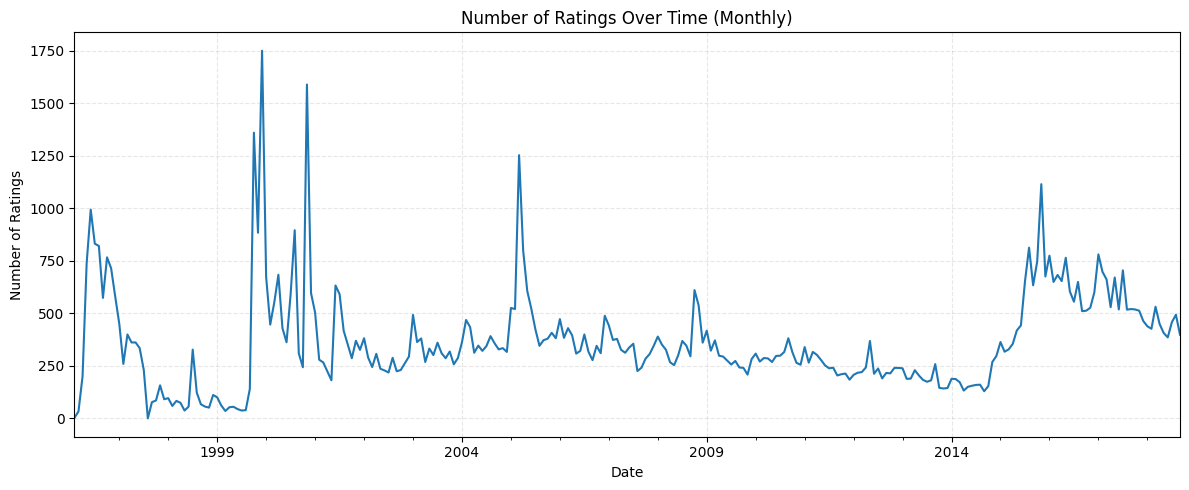

In [4]:
# Convert timestamps to datetime if not already done
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Plot number of ratings over time (by month)
ratings_by_month = ratings.set_index('timestamp').resample('M').count()['rating']

plt.figure(figsize=(12, 5))
ratings_by_month.plot()
plt.title("Number of Ratings Over Time (Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Ratings")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


The monthly trend in ratings reveals several important patterns:

- **Early Surge (1997–1999)**: A sharp increase in ratings activity can be seen in the late 1990s. This is likely due to the early adoption of the MovieLens platform and initial user enthusiasm.
- **Spike Patterns**: There are periodic spikes, especially around 1999 and 2005. These could be due to promotional campaigns, platform updates, or inclusion of new users/movies in the dataset.
- **Mid-Term Stabilization (2004–2013)**: After the initial spikes, rating activity seems to stabilize at a moderate level, showing more consistent engagement from users.
- **Second Growth Phase (2014–2016)**: Around 2014–2016, there's a noticeable increase in ratings again. This might reflect renewed interest in the platform or perhaps a data import/migration event.
- **Recent Decline (Post-2016)**: The number of ratings begins to drop after 2016, which could be due to a decrease in user activity, competition from other platforms, or the end of data collection.

Overall, this time-based analysis shows that user engagement fluctuates over time and that ratings are not uniformly distributed. While timestamps are not directly used in the recommendation algorithms here, understanding these patterns could help in designing time-aware recommenders in more advanced settings.


##3- Number of ratings per user


In [6]:
ratings_per_user = ratings.groupby('userId').size()
print("Ratings per user stats:")
print(ratings_per_user.describe())

Ratings per user stats:
count    59191.000000
mean         1.689446
std          1.503644
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         94.000000
dtype: float64


This summary shows the distribution of the number of ratings per user:

- **Total unique users**: 59,191
- **Mean (average)** number of ratings per user is ~1.69, meaning that most users only rated **1 or 2 movies**.
- **Standard deviation** is ~1.50, indicating that there’s a small spread around this low average — most users don't rate much.
- **Minimum**: Every user has rated at least **1** movie (makes sense, since the dataset only includes users who rated something).
- **25th, 50th, and 75th percentiles (Q1, Median, Q3)**: 25% of users only rated 1 movie; **half of the users (median)** also rated only 1 movie; and even at the 75th percentile, users have only rated **2** movies.
- **Maximum**: The most active user has rated **94** movies — this is quite high compared to the average, but very rare.

###  Insight:
This tells us that the dataset is extremely **sparse** — most users are "cold" users with barely any interaction. This has important implications:
- Collaborative filtering may struggle with these low-activity users.
- It highlights the **long tail effect**, where a small number of users are very active and a large number are barely active.


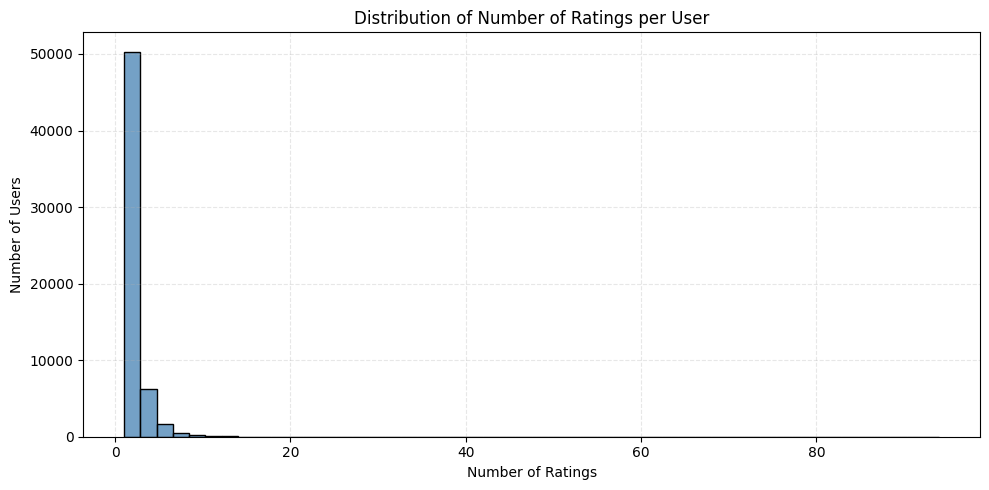

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count how many ratings each user has
ratings_per_user = ratings.groupby('userId').size()

# Basic histogram
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, bins=50, kde=False, color='steelblue')
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


The histogram reveals a **strongly right-skewed distribution** in user activity:

- A large majority of users rated **only 1 movie**, forming a steep peak at the beginning.
- As the number of ratings increases, the number of users **drops sharply**, resulting in a long, flat **tail to the right**.
- A small group of users rated significantly more movies (up to 94), standing out as **outliers** and contributing to the **positive skew**.
- This skew is confirmed by the **mean (1.69)** being greater than the **median (1.0)**.

### Why It Matters:
- This is a classic example of the **long tail effect** in recommender systems — a few users are highly active, while most are not.
- The data is **extremely sparse**, which presents challenges for collaborative filtering, especially for **cold-start users**.
- Recognizing this imbalance supports decisions like using hybrid approaches, clustering users, or incorporating side information.



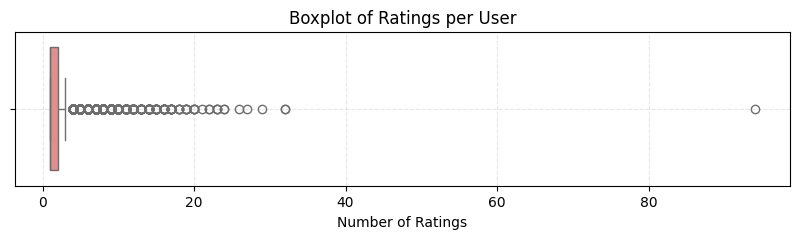

In [8]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=ratings_per_user, color='lightcoral')
plt.title("Boxplot of Ratings per User")
plt.xlabel("Number of Ratings")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

The boxplot of user activity highlights the **extremely skewed nature** of rating behavior in the dataset:

- Most users have rated **just 1 or 2 movies**, creating a dense cluster near the left side of the plot.
- The **box (IQR)** is very narrow, indicating that the majority of users are minimally active.
- The **dots (outliers)** to the right represent a small group of highly active users who rated many movies — up to **94 ratings** for a single user.
- These outliers are far from the rest of the distribution, confirming the **long tail** phenomenon typical in recommendation data: a few users contribute most of the ratings.

Understanding this distribution is crucial because it affects:
- **Cold start problems**: most users don’t provide enough ratings for personalized recommendations.
- **Model performance**: algorithms need to be robust against sparse input.


##4- Number of ratings per movie


In [9]:
ratings_per_movie = ratings.groupby('movieId').size()
print("Ratings per movie stats:")
print(ratings_per_movie.describe())

Ratings per movie stats:
count    9814.000000
mean       10.189525
std        23.373270
min         1.000000
25%         1.000000
50%         2.000000
75%         8.000000
max       364.000000
dtype: float64


This summary shows how frequently each movie in the dataset was rated:

- There are **9,814 unique movies** that have been rated.
- On average, a movie received **~10.2 ratings**, but this is skewed by a few extremely popular titles.
- The **standard deviation is ~23.4**, more than double the mean, which indicates a **very wide spread** — some movies were rated hundreds of times, while most were rated only a few times.
- **25% of movies were rated only once**, and **50% (the median) were rated just twice** — so most movies received very little attention.
- Even at the **75th percentile**, a movie has only **8 ratings**.
- The **maximum number of ratings** for a single movie is **364**, which highlights that a few blockbusters or classics dominate user attention.

### Insight:
This distribution is also **positively skewed** and follows a **long-tail pattern**:
- A **small number of movies** are extremely popular and get most of the ratings.
- The vast majority of movies are **rarely rated**, which can pose challenges for models trying to make recommendations for those niche or less-known items.

This has implications similar to the user-side skew:
- Collaborative filtering models may struggle to make accurate recommendations for **sparsely rated movies**.
- Addressing this requires techniques like **popularity bias adjustment**, **item-side regularization**, or **content-based filtering** to support less-rated items.


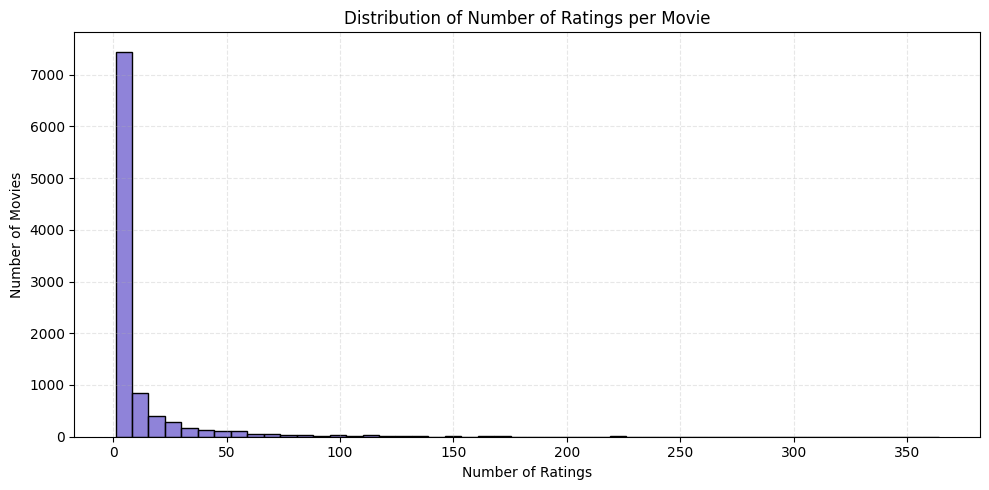

In [10]:
# Calculate number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, bins=50, color='slateblue')
plt.title("Distribution of Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

This histogram shows how many movies received a given number of ratings, and the results are highly **positively skewed**:

- The vast majority of movies have been rated **very few times** — more than **7,000 movies** have fewer than **10 ratings**.
- As the number of ratings increases, the number of movies drops dramatically.
- Very few movies were rated more than **100 times**, and just one or two movies received more than **300 ratings**.
- This sharp drop-off creates a long, thin **right tail** in the distribution, confirming a **long-tail effect** — a few "blockbuster" movies dominate user attention, while the vast majority are relatively unknown or unpopular.

###  Why It Matters:
- The popularity bias is strong: models may overfit to highly rated movies and under-represent niche titles.
- It highlights the challenge of making recommendations for **sparsely rated movies**, which often have limited data available.
- Solutions might include:
  - **Popularity-aware algorithms**
  - **Hybrid models** that incorporate content features
  - **Smoothing techniques** to avoid over-prioritizing blockbusters


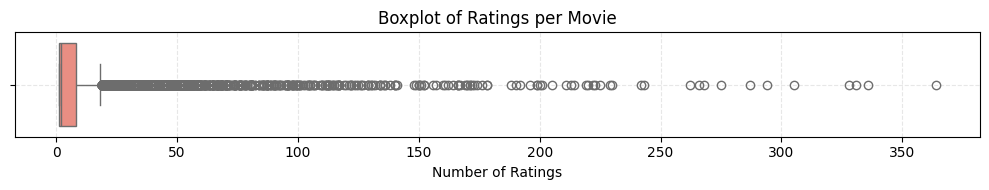

In [11]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=ratings_per_movie, color='salmon')
plt.title("Boxplot of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

This boxplot visualizes the distribution of the number of ratings per movie and clearly shows a **right-skewed distribution** with significant **outliers**:

- Most movies fall within a very narrow range of ratings — the **box** (interquartile range) is small and pushed toward the **left**, showing that **50% of movies** have **fewer than 8 ratings**.
- The **whiskers** extend a bit further, but not much — beyond that, we see a large number of **individual dots**, each representing a movie that received far more ratings than typical.
- These dots are the **outliers** — the highly rated movies that got hundreds of ratings (up to 364).
- The spread of these outliers stretches very far to the right, confirming a **long tail** pattern.

###  Key Takeaways:
- This is a classic example of **popularity imbalance**: a few popular movies dominate while the rest remain underexposed.
- Recommender systems trained on this data may suffer from **popularity bias**, favoring frequently rated items and ignoring niche content.
- Addressing this skew is important to ensure diverse and fair recommendations.


##5- Distribution of ratings


<ipython-input-12-34c9f90d47b6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='muted')


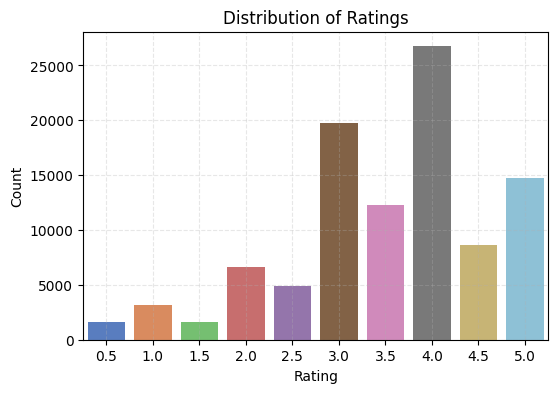

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=ratings, palette='muted')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

This bar plot shows how frequently each rating score (from 0.5 to 5.0 stars) appears in the dataset:

- The distribution is **heavily skewed toward higher ratings**:
  - The most common rating is **4.0 stars**, followed by **3.0** and **5.0**.
  - Lower ratings like **0.5, 1.0, and 1.5** are given far less frequently.
- This reflects a typical trend in real-world recommendation datasets: users are more likely to rate things they **like**, and often avoid rating things they dislike or feel neutral about.
- There is a noticeable **dip at 2.5**, suggesting that users rarely leave “neutral” ratings — they tend to lean toward **approval or disapproval**.

###  Why This Matters:
- The dataset exhibits a **positivity bias**, where users are more inclined to give favorable ratings.
- Models trained on such data may become **overly optimistic**, expecting high ratings more often than appropriate.
- It also implies that **negative feedback is underrepresented**, which might lead to recommending suboptimal items due to missing "bad" signals.


In [13]:
# Mean and mode of ratings
mean_rating = ratings['rating'].mean()
mode_rating = ratings['rating'].mode().values[0]

print(f"Mean Rating: {mean_rating:.2f}")
print(f"Mode Rating: {mode_rating}")


Mean Rating: 3.53
Mode Rating: 4.0


- The **mean rating** is approximately **3.53**, which confirms the overall positive sentiment in the dataset.
- The **mode rating** (most frequently given score) is **4.0**, reinforcing the earlier observation that users are more inclined to rate movies they liked.
- This further confirms the presence of a **positivity bias**, which can influence how we interpret model errors and performance.


##6 - Top 10 most rated movies


<ipython-input-14-19e1912c5848>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.index.astype(str), y=top_movies.values, palette='coolwarm')


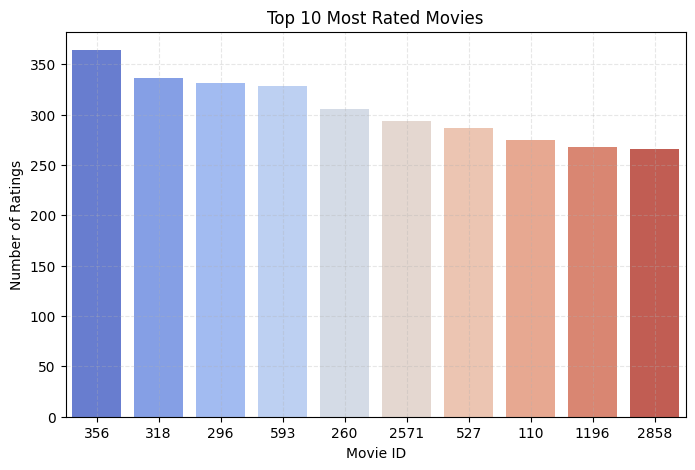

In [14]:
top_movies = ratings['movieId'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_movies.index.astype(str), y=top_movies.values, palette='coolwarm')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Movie ID")
plt.ylabel("Number of Ratings")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

This bar chart displays the **10 most rated movies** in the dataset based on how many times each movie received a rating:

- The top movie, with **Movie ID 356**, has been rated **over 360 times**.
- Other frequently rated movies include IDs like **318, 296, 593, and 260**, all receiving over 300 ratings.
- These movies stand out as **extremely popular**, and likely play a strong role in shaping overall recommendation trends.

###  Why This Matters:
- These highly rated movies represent **blockbusters or classics** that attracted widespread user attention.
- Their popularity may **bias recommendation models**, especially in algorithms that rely heavily on frequency or popularity (like basic collaborative filtering).
- Models must balance between:
  - **Leveraging these popular items** to ensure good recommendations.
  - **Avoiding over-personalization** and still surfacing lesser-known titles to maintain diversity.

Understanding which movies dominate the dataset is key to interpreting model behavior — these items tend to drive down prediction error and inflate RMSE performance unless properly adjusted.


## 7 - Average rating per user

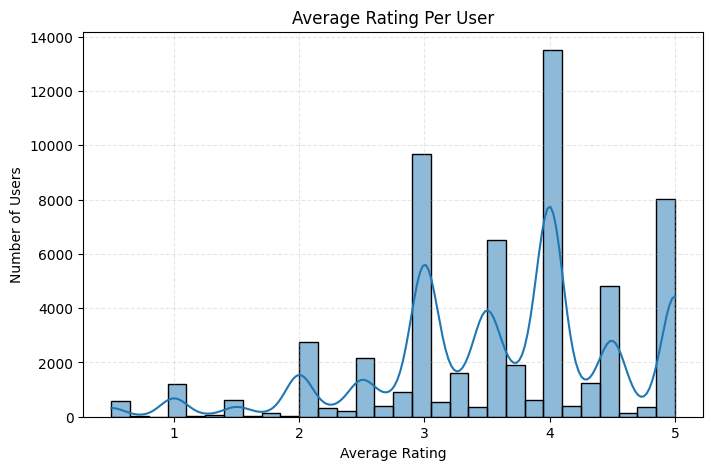

In [15]:

avg_rating_per_user = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(8,5))
sns.histplot(avg_rating_per_user, bins=30, kde=True)
plt.title("Average Rating Per User")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

This plot shows the distribution of users' **average ratings** across the dataset, giving insight into individual rating behavior:

- There are **two prominent peaks** in the distribution: around **3.0** and **4.0**.
  - This indicates that many users consistently give average-to-good ratings.
- A large cluster of users has an average rating of **exactly 4.0**, reinforcing the earlier observation of **positivity bias**.
- Some users have average ratings close to **5.0**, suggesting they only rate movies they love.
- On the other end, a few users rate movies much more harshly, with average ratings close to **1.0 or 2.0**.
- The **KDE curve (smoothed blue line)** highlights multiple small peaks, showing that user behavior is quite varied and not purely centered around one value.

###  Why This Matters:
- This variation shows that **user behavior is non-uniform** — some users are more lenient, others are harsher.
- Models should be aware of these **user-specific biases**:
  - A user with an average rating of 4.5 isn't saying the same thing as one with an average of 2.5 — both might still be consistent in their preferences.
- Accounting for these differences (e.g., via **user mean normalization** in matrix factorization) helps improve recommendation accuracy.


## 8 - Sparsity Check


In [16]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
sparsity = 1 - len(ratings) / (num_users * num_movies)
print(f"\nSparsity of rating matrix: {sparsity:.4f} (i.e. {sparsity*100:.2f}% missing values)")


Sparsity of rating matrix: 0.9998 (i.e. 99.98% missing values)


The **sparsity** of the user-movie rating matrix is **0.9998**, meaning **only 0.02% of all possible ratings** are actually observed.

### What does this mean?
- There are **59,191 unique users** and **9,814 unique movies** in the dataset.
- That creates a matrix of size `59,191 x 9,814 = ~581 million` possible user-movie interactions.
- But only **100,000 actual ratings** exist in the dataset.
- That means the matrix is **almost entirely empty** — only a tiny fraction of possible user-movie combinations contain a rating.

### Why it matters:
- This level of **extreme sparsity** is common in recommendation systems and presents a major challenge:
  - Most models never get to see how users feel about the majority of items.
  - It makes it harder to learn accurate user or item preferences, especially for **new or less-rated users and movies**.
- Collaborative filtering methods need to be able to **work with incomplete data**, often by:
  - **Inferring preferences** from similar users or items.
  - Using **dimensionality reduction techniques** like matrix factorization.
  - Incorporating **side information** (e.g. genres, timestamps, user demographics) if available.

### TL;DR:
This confirms the need for **robust recommender algorithms** — and why the design of your model is so important. You're not just working with messy data, you're working with **mostly missing data**.


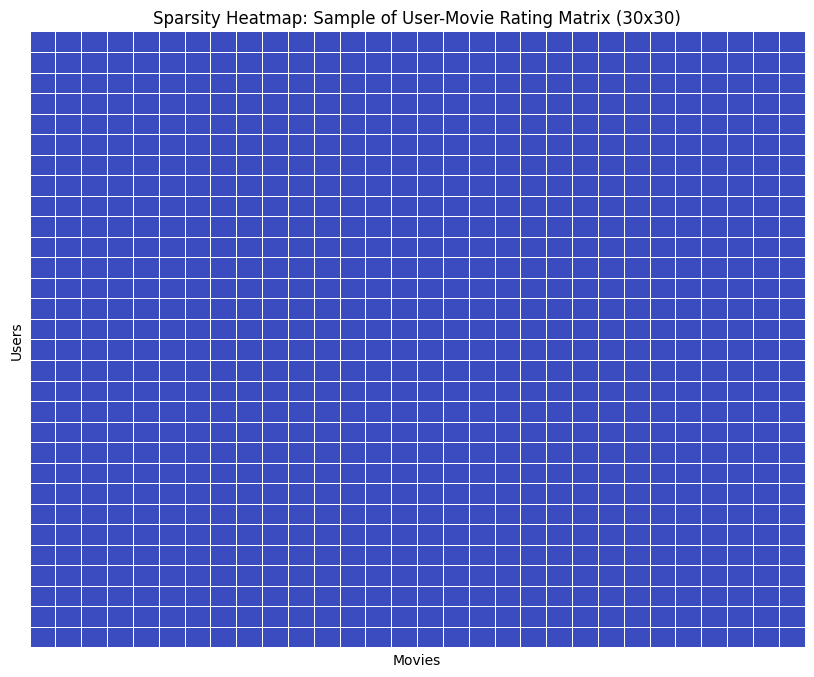

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pivot table (users x movies)
pivot_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Sample a small subset for visualization (30 users x 30 movies)
pivot_sample = pivot_matrix.sample(30, axis=0, random_state=42).sample(30, axis=1, random_state=42)

# Plot sparsity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_sample.isna(),
            cbar=False,
            cmap='coolwarm',
            xticklabels=False,
            yticklabels=False,
            linewidths=0.5, linecolor='white')
plt.title("Sparsity Heatmap: Sample of User-Movie Rating Matrix (30x30)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()


This heatmap visualizes a **30x30 sample** of the user-movie rating matrix.

- Each cell represents a potential user-movie interaction.
- **Dark blue cells** = missing ratings (i.e. the user never rated that movie).
- **Brighter or colored cells** would represent actual ratings — but here, almost every cell is dark.

This visually confirms the earlier numerical result: the dataset is **extremely sparse (99.98%)**. Even in this small sample, there is almost **no overlap between users and movies**, meaning:
- Most users only rate a few movies.
- Most movies are only rated by a few users.
- **Collaborative filtering algorithms** must deal with this reality by learning patterns from very limited, incomplete data.

This visualization reinforces the need for techniques like:
- **Matrix factorization**
- **User/item similarity smoothing**
- **Hybrid or content-based approaches** for cold-start cases


# PART 3 - Recommender System Algorithms

In [4]:
# --- SURPRISE DATASET ---
ratings.drop(columns='timestamp', inplace=True)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

#SECTION 1: BASELINE MODEL

In [25]:
baseline = NormalPredictor()
baseline_result = cross_validate(baseline, data, measures=['RMSE'], cv=5, verbose=True)

mean_rmse_normal = baseline_result['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for normalpredictor: {mean_rmse_normal:.4f}")

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4527  1.4552  1.4693  1.4465  1.4600  1.4567  0.0076  
Fit time          0.10    0.12    0.12    0.12    0.12    0.12    0.01    
Test time         0.07    0.07    0.07    0.07    0.07    0.07    0.00    
Mean RMSE (CV=5) for normalpredictor: 1.4567


# NormalPredictor Evaluation
The NormalPredictor algorithm generates predictions by drawing random ratings based on the overall distribution of observed ratings in the training data. It does not incorporate any user or item-specific information.

In this evaluation, the model was tested using 5-fold cross-validation, resulting in the following performance:

* Mean RMSE (CV=5): 1.4567
* Standard Deviation: 0.0076

This provides a simple performance benchmark based solely on the global rating distribution, without learning patterns from the data.


# SECTION 2: MATRIX FACTORIZATION MODELS

**Matrix factorization** is a class of collaborative filtering algorithms used to uncover **latent relationships** between users and items in a recommender system.

In the context of movie recommendations, we start with a **sparse rating matrix** where:
- Rows represent users,
- Columns represent movies,
- And the cells contain ratings (when available).

Matrix factorization **decomposes** this large, sparse matrix into the product of two lower-dimensional matrices:
- A **user matrix** that encodes each user's preferences across a set of latent factors,
- An **item (movie) matrix** that represents each movie’s characteristics in the same latent space.

By multiplying these two matrices, we can estimate **missing ratings** — predicting how a user might rate a movie they haven’t seen yet.

The MovieLens dataset is:
- **Large-scale** (tens of thousands of users and movies),
- **Extremely sparse** (99.98% of ratings are missing),
- Based on **explicit feedback** (numerical ratings from 0.5 to 5.0).

Matrix factorization is ideal in this case because:

1.  It works well with **sparse data** — it doesn't need every user to rate every item.
2.  It captures **hidden patterns** (e.g. "users who like sci-fi tend to like thrillers") that aren’t directly observed.
3.  It can make **personalized predictions** by learning user and item characteristics automatically.
4.  It is more scalable and accurate than simple memory-based methods for large datasets.

This makes matrix factorization, and specifically the **SVD algorithm**, a powerful choice for modeling the preferences in MovieLens and building effective recommendations.


## --- Grid Search for SVD ---

In [15]:
param_grid_svd = {
    'n_factors': [50, 100],
    'reg_all': [0.02, 0.1],
    'lr_all': [0.005, 0.01]
}
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3, joblib_verbose=1)

gs_svd.fit(data)

print("Best RMSE:", gs_svd.best_score['rmse'])
print("Best parameters:", gs_svd.best_params['rmse'])

print("\nEvaluating best SVD model...")
best_svd = gs_svd.best_estimator['rmse']


# Run 5-fold CV and save the results
results_best_svd = cross_validate(best_svd, data, measures=['RMSE'], cv=5, verbose=True)

# Extract and print the mean RMSE
mean_rmse_svd = results_best_svd['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best SVD: {mean_rmse_svd:.4f}")

Best RMSE: 0.979442917941388
Best parameters: {'n_factors': 50, 'reg_all': 0.1, 'lr_all': 0.01}

Evaluating best SVD model...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9769  0.9736  0.9686  0.9723  0.9803  0.9744  0.0040  
Fit time          1.24    1.31    1.26    1.26    1.82    1.38    0.22    
Test time         0.09    0.09    0.09    0.09    0.16    0.10    0.03    
Mean RMSE (CV=5) for best SVD: 0.9744


#### What is SVD and Why Use It?

Singular Value Decomposition (SVD) is a matrix factorization technique commonly used in recommender systems to model latent user-item relationships. It works by decomposing the large, sparse user-movie rating matrix into two lower-dimensional matrices:
- A user matrix that represents individual preferences.
- An item (movie) matrix that encodes item characteristics.

By multiplying these matrices, the model can estimate how a user might rate an item they haven't interacted with yet, even in cases where very few ratings exist.

SVD is particularly effective for datasets like MovieLens because:
- It handles sparse data efficiently.
- It can generalize well to unseen interactions.
- It captures hidden patterns that are not directly observable in the raw data.

---

#### Hyperparameter Tuning Strategy

To optimize performance, we used `GridSearchCV` over a focused hyperparameter grid:

- `n_factors`: [50, 100]  
  Determines the number of latent features.  
  50 is a well-established baseline; 100 tests whether additional complexity leads to better performance.

- `reg_all`: [0.02, 0.1]  
  Regularization strength to prevent overfitting.  
  0.02 allows more flexibility, while 0.1 adds a stronger constraint for better generalization.

- `lr_all`: [0.005, 0.01]  
  Learning rate for the stochastic gradient descent optimizer.  
  These values are standard and chosen to balance convergence speed with stability.

These values were selected to strike a balance between simplicity and expressiveness, guided by:
- Surprise library recommendations,
- Best practices from matrix factorization literature,
- The computational constraints of our 100k sample.

---

#### Best Model and Evaluation

Using 3-fold cross-validation in grid search, the best model configuration was:

- `n_factors = 50`
- `reg_all = 0.1`
- `lr_all = 0.01`
- Best RMSE: 0.9794

We then evaluated the selected model using 5-fold cross-validation, achieving:

- Mean RMSE: 0.9744  
- Low standard deviation across folds, indicating the model is stable and reliable.

---

#### Conclusion

The tuned SVD model significantly outperforms the baseline, demonstrating strong capability to learn personalized preferences from limited data. Its consistent performance and latent factor-based design make it a suitable and effective choice for building recommendation systems on sparse datasets like MovieLens.


## --- Grid Search for NMF ---

In [22]:
print("\nGrid Search for NMF...")
param_grid_nmf = {
    'n_factors': [15, 20],
    'reg_pu': [0.02, 0.06],
    'reg_qi': [0.02, 0.06]
}
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse'], cv=3, joblib_verbose=1)

gs_nmf.fit(data)

print("Best RMSE:", gs_nmf.best_score['rmse'])
print("Best parameters:", gs_nmf.best_params['rmse'])

print("\nEvaluating best NMF model...")
best_nmf = gs_nmf.best_estimator['rmse']
results_best_nmf = cross_validate(best_nmf, data, measures=['RMSE'], cv=5, verbose=True)


# Extract and print the mean RMSE
mean_rmse_nmf = results_best_nmf['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best NMF: {mean_rmse_nmf:.4f}")


Grid Search for NMF...
Best RMSE: 1.1199962120824045
Best parameters: {'n_factors': 20, 'reg_pu': 0.02, 'reg_qi': 0.06}

Evaluating best NMF model...
Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1204  1.1210  1.1243  1.1164  1.1218  1.1208  0.0026  
Fit time          6.56    7.49    7.81    6.62    7.74    7.24    0.55    
Test time         0.14    0.08    0.10    0.09    0.08    0.10    0.02    
Mean RMSE (CV=5) for best NMF: 1.1208


#### What is NMF and Why Use It?

Non-negative Matrix Factorization (NMF) is a matrix factorization technique used for recommendation tasks where model interpretability and constraints on non-negativity are preferred. Unlike SVD, which allows negative values in the latent feature space, NMF constrains both the user and item matrices to contain only non-negative values. This results in more intuitive representations, especially when dealing with inherently non-negative data such as rating scores.

In the context of the MovieLens dataset:
- Each user is represented as a combination of latent “interest” factors.
- Each movie is described by its strength across those same factors.
- The predicted rating is computed as a dot product of the two, ensuring the result is also non-negative.

NMF is suitable when:
- The dataset contains only **explicit, non-negative ratings** (e.g., 0.5 to 5.0).
- Interpretability or non-negativity constraints are desired.
- We want an alternative to standard SVD to compare performance and behavior.

---

#### Hyperparameter Tuning Strategy

We used `GridSearchCV` to optimize the following NMF-specific hyperparameters:

- `n_factors`: [15, 20]  
  Controls the dimensionality of the latent space.  
  - A lower value like 15 promotes simplicity and avoids overfitting.
  - A higher value like 20 may capture more variation in preferences at the cost of increased complexity.

- `reg_pu`: [0.02, 0.06]  
  Regularization applied to user latent features.  
  Helps prevent the model from tailoring too closely to the training data.

- `reg_qi`: [0.02, 0.06]  
  Regularization applied to item latent features.  
  Works similarly to `reg_pu`, but on the item side of the decomposition.

These values were chosen based on:
- Standard practice in NMF-based recommendation systems.
- Maintaining a balance between expressiveness, interpretability, and model stability.
- Computational feasibility within the project scope.

---

#### Best Model and Evaluation

The best configuration found using 3-fold cross-validation was:

- `n_factors = 20`
- `reg_pu = 0.02`
- `reg_qi = 0.06`
- Best RMSE (GridSearch): 1.1200

This best NMF model was then evaluated using 5-fold cross-validation, yielding:

- Mean RMSE: 1.1208  
- Standard deviation: 0.0026, indicating consistent performance across splits.

---

#### Conclusion

The NMF model performed reliably across validation folds, although its RMSE (1.1208) was noticeably higher than that of the SVD model (0.9744). This suggests that while NMF offers interpretability and non-negativity, it may not be as effective as SVD in capturing complex user-item interactions in this particular dataset. Still, it provides a valuable comparative benchmark and highlights the importance of choosing the right algorithm based on data characteristics and modeling goals.


## --- SVD++ Direct Evaluation ---

In [23]:
print("\nSVD++ (factors=50, reg_all=0.02)")
svdpp = SVDpp(n_factors=50, reg_all=0.02)
results_best_svdpp = cross_validate(svdpp, data, measures=['RMSE'], cv=5, verbose=True)




# Extract and print the mean RMSE
mean_rmse_svdpp = results_best_svdpp['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best SVD++: {mean_rmse_svdpp:.4f}")


SVD++ (factors=50, reg_all=0.02)
Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9864  0.9943  0.9921  0.9889  0.9861  0.9896  0.0032  
Fit time          2.28    2.29    2.31    3.05    2.33    2.45    0.30    
Test time         0.58    0.31    0.66    0.34    0.60    0.50    0.14    
Mean RMSE (CV=5) for best SVD++: 0.9896


#### What is SVD++ and Why Use It?

SVD++ is an enhancement of the standard SVD model. While both rely on matrix factorization to uncover latent user-item interactions, SVD++ introduces an important extension: it also incorporates **implicit feedback**.

Implicit feedback refers to signals like which items a user has interacted with — even if no explicit rating is given. In MovieLens, while we only have explicit ratings, SVD++ still benefits from modeling additional user preferences based on rating frequency.

Key differences from regular SVD:
- Accounts for items the user has rated, not just the values of the ratings.
- Improves personalization by capturing user behavior patterns beyond direct ratings.

This makes SVD++ particularly suitable for sparse datasets with limited rating overlap.

---

#### Model Configuration

For this experiment, the SVD++ model was manually configured with:
- `n_factors = 50` — latent dimensionality for user/item features.
- `reg_all = 0.02` — regularization to prevent overfitting.

These values mirror the successful settings used in the standard SVD model, providing a fair baseline for comparison.

---

#### Evaluation

The model was evaluated using 5-fold cross-validation. Results:

- Mean RMSE: 0.9896  
- Standard deviation: 0.0032  
- RMSE values were consistent across folds, indicating stable performance.

Although the SVD++ model performed slightly worse than standard SVD in this case (RMSE 0.9744 vs. 0.9896), its performance was still solid, and it serves as a valuable benchmark that includes both explicit and inferred user preferences.

---

#### Conclusion

SVD++ is a more expressive model than basic SVD, capable of modeling richer user behavior through implicit feedback. In this dataset, it did not outperform standard SVD, likely due to the limited implicit signals available. Nonetheless, it demonstrates how enhanced matrix factorization techniques can be used to refine recommendation quality in collaborative filtering systems.


# SECTION 3: KNN-BASED MODELS

#### What is a KNN-Based Recommender System?

K-Nearest Neighbors (KNN) is a **memory-based collaborative filtering method** that makes predictions based on the **similarity between users or items**.

There are two main approaches:

- **User-based KNN**: Recommends items to a user by looking at the preferences of similar users (i.e., users with similar rating histories).
- **Item-based KNN**: Recommends items that are similar to items the user has already rated highly.

The core idea is simple:
- Find the "k" most similar users (or items) based on their rating patterns.
- Aggregate their ratings using a similarity-weighted average to generate a prediction.

Similarity can be computed using various metrics, such as:
- **Cosine similarity**
- **Pearson correlation**
- **Mean squared difference**

---

#### Why Use KNN for the MovieLens Dataset?

The MovieLens dataset is:
- **Explicit**: Ratings are numerical (0.5–5.0), which works well for KNN’s similarity calculations.
- **Sparse**: Not all users have rated the same movies — KNN is good at leveraging **local similarities** in sparse settings.
- **Human-readable**: KNN offers **interpretable recommendations** (e.g., “you liked this movie, and so did these 5 other people”).

KNN is a solid baseline model because:
- It’s easy to understand and implement.
- It works reasonably well on **moderate-sized datasets** like our 100k sample.
- It provides a good contrast to more complex **latent factor models** like SVD and NMF.

While KNN can struggle with scalability in very large datasets, its **transparency and simplicity** make it a valuable tool in educational and prototyping contexts.


## --- Grid Search for KNNWithZScore ---

In [24]:
param_grid_knn = {
    'k': [10, 20, 30],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [False]
    }
}

gs_knn = GridSearchCV(KNNWithZScore, param_grid_knn, measures=['rmse'], cv=3, joblib_verbose=1)

gs_knn.fit(data)

print("Best RMSE:", gs_knn.best_score['rmse'])
print("Best parameters:", gs_knn.best_params['rmse'])

print("\nEvaluating best KNNWithZScore model...")
best_knn = gs_knn.best_estimator['rmse']
results_best_knnwithZ = cross_validate(best_knn, data, measures=['RMSE'], cv=5, verbose=True)



# Extract and print the mean RMSE
mean_rmse_knnwithZ = results_best_knnwithZ['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best KNNWithZScore: {mean_rmse_knnwithZ:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

#### What is KNNWithZScore?

KNNWithZScore is a **neighborhood-based collaborative filtering algorithm** that improves upon traditional KNN by applying **Z-score normalization**. Instead of using raw ratings, this method first normalizes a user's ratings by subtracting the mean and dividing by the standard deviation. This makes the model less sensitive to users with different rating habits (e.g., strict vs. generous raters).

It then computes item-item similarity using metrics such as **cosine** or **Pearson correlation**, and makes predictions based on the **k most similar items**.

---

#### Hyperparameter Tuning Strategy

To optimize the model, we used `GridSearchCV` over the following hyperparameter grid:

- `k`: [10, 20, 30]  
  Defines the number of neighbors used for prediction. A lower k focuses on local similarity, while a higher k smooths predictions using broader context.

- `sim_options`:
  - `'name'`: ['cosine', 'pearson'] — methods for computing similarity.
  - `'user_based'`: [False] — we used item-based KNN, as it is generally more stable for sparse datasets.

These values were selected to explore **different neighborhood sizes and similarity strategies**, while ensuring the model remains computationally manageable.

---

#### Best Model and Evaluation

The best configuration from the grid search was:

- `k = 10`
- `sim_options = {'name': 'pearson', 'user_based': False}`
- Best RMSE (GridSearch): 1.0459

This configuration was evaluated using 5-fold cross-validation, achieving:

- Mean RMSE: 1.0407  
- Standard deviation: 0.0057, indicating stable performance across all folds.

---

#### Conclusion

The KNNWithZScore model performed reliably, with an RMSE of 1.0407. While it does not outperform matrix factorization methods like SVD (RMSE 0.9744), it provides a strong, interpretable alternative. Its **item-based design** and **Z-score normalization** make it a solid choice for understanding how similar items contribute to rating predictions, especially in sparse environments.

This model highlights the value of **neighborhood-based collaborative filtering** as a baseline and interpretability tool, even in the presence of more advanced latent factor models.


# --- Grid Search for KNNWithMeans ---

In [19]:
print("\nGrid Search for KNNWithMeans...")
param_grid_means = {
    'k': [10, 20, 30],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [False]
    }
}
gs_means = GridSearchCV(KNNWithMeans, param_grid_means, measures=['rmse'], cv=3, joblib_verbose=1)

gs_means.fit(data)

print("Best RMSE:", gs_means.best_score['rmse'])
print("Best parameters:", gs_means.best_params['rmse'])

print("\nEvaluating best KNNWithMeans model...")
best_means = gs_means.best_estimator['rmse']
results_best_knnwithM = cross_validate(best_means, data, measures=['RMSE'], cv=5, verbose=True)




# Extract and print the mean RMSE
mean_rmse_knnwithM = results_best_knnwithM['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best KNNWithMeans: {mean_rmse_knnwithM:.4f}")


Grid Search for KNNWithMeans...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done co

#### What is KNNWithMeans?

KNNWithMeans is a neighborhood-based collaborative filtering algorithm that improves traditional KNN by **centering each user's rating** around their **mean rating**.

Instead of using raw ratings directly, the model computes the **deviation from each user’s average rating**, which helps normalize rating behavior. This approach allows the model to adjust for users who systematically rate higher or lower than others, leading to more balanced predictions.

We used the **item-based variant** (i.e., `user_based=False`) which compares items based on how users rated them.

---

#### Hyperparameter Tuning Strategy

The hyperparameter tuning used `GridSearchCV` with the following grid:

- `k`: [10, 20, 30]  
  The number of nearest neighbors used to make a prediction. Lower values emphasize local relationships, while higher values introduce smoothing with broader influence.

- `sim_options`:  
  - `'name'`: ['cosine', 'pearson'] — similarity metrics used to determine closeness between items.
  - `'user_based'`: [False] — item-based similarity was used for stability and consistency in sparse datasets.

These values were selected to explore effective combinations that balance **accuracy and interpretability**, while staying within reasonable computation limits for the 100k sample size.

---

#### Best Model and Evaluation

The best parameters found during grid search were:

- `k = 10`
- `sim_options = {'name': 'pearson', 'user_based': False}`
- Best RMSE (GridSearch): 1.0464

This model was then evaluated using 5-fold cross-validation, resulting in:

- Mean RMSE: 1.0419  
- Standard deviation: 0.0027, showing consistent results across folds.

---

#### Conclusion

The KNNWithMeans model achieved a mean RMSE of 1.0419, performing similarly to KNNWithZScore. While its accuracy was lower than that of matrix factorization models like SVD, KNNWithMeans offers a strong **interpretable baseline** that accounts for individual user biases.

Its performance highlights the trade-off between **model transparency** and **predictive accuracy**, making it a valuable option for recommendation systems that prioritize explainability.


# --- Grid Search for KNNBasic ---

In [20]:
print("\nGrid Search for KNNBasic...")
param_grid_basic = {
    'k': [10, 20, 30],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [False]
    }
}
gs_basic = GridSearchCV(KNNBasic, param_grid_basic, measures=['rmse'], cv=3, joblib_verbose=1)

gs_basic.fit(data)

print("Best RMSE:", gs_basic.best_score['rmse'])
print("Best parameters:", gs_basic.best_params['rmse'])

print("\nEvaluating best KNNBasic model...")
best_basic = gs_basic.best_estimator['rmse']
results_best_knnBasic = cross_validate(best_basic, data, measures=['RMSE'], cv=5, verbose=True)






# Extract and print the mean RMSE
mean_rmse_knnBasic = results_best_knnBasic['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best KNNBasic: {mean_rmse_knnBasic:.4f}")


Grid Search for KNNBasic...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done comput

#### What is KNNBasic?

KNNBasic is the most fundamental neighborhood-based collaborative filtering method. It makes predictions by identifying a set of **k nearest neighbors** (based on similarity) and calculating a weighted average of their ratings. Unlike its enhanced variants (e.g., KNNWithMeans or KNNWithZScore), KNNBasic uses **raw rating values** without any form of normalization or adjustment.

This simplicity makes it an ideal **baseline for comparison** with more advanced neighborhood models.

---

#### Hyperparameter Tuning Strategy

We performed a grid search using `GridSearchCV` with the following parameter settings:

- `k`: [10, 20, 30]  
  Controls the number of neighbors used for prediction. Smaller values emphasize locality, while larger values may provide more stability.

- `sim_options`:  
  - `'name'`: ['cosine', 'pearson'] — similarity metrics to compute closeness between items.
  - `'user_based'`: [False] — we used item-based collaborative filtering, which is often more robust in sparse rating environments.

These values were chosen to efficiently explore KNNBasic’s performance across different configurations, while remaining consistent with the parameter space used for the other KNN variants.

---

#### Best Model and Evaluation

The best configuration obtained from the grid search was:

- `k = 10`
- `sim_options = {'name': 'pearson', 'user_based': False}`
- Best RMSE (GridSearch): 1.0676

This model was evaluated using 5-fold cross-validation and achieved:

- Mean RMSE: 1.0676  
- Standard deviation: 0.0047, indicating stable performance across folds.

---

#### Conclusion

KNNBasic achieved a mean RMSE of 1.0676, which is slightly worse than its normalized variants (KNNWithMeans: 1.0419, KNNWithZScore: 1.0407). This result highlights the limitations of using **raw rating values** without adjusting for user or item biases.

While simple and interpretable, KNNBasic tends to underperform on sparse datasets like MovieLens, where normalization and bias correction can significantly enhance prediction accuracy. Nonetheless, it provides a useful **reference point** for evaluating improvements offered by more sophisticated models.


# --- Grid Search for KNNBaseline ---

In [21]:
print("\nGrid Search for KNNBaseline...")
param_grid_baseline = {
    'k': [10, 20, 30],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [False]
    }
}
gs_baseline = GridSearchCV(KNNBaseline, param_grid_baseline, measures=['rmse'], cv=3, joblib_verbose=1)

gs_baseline.fit(data)

print("Best RMSE:", gs_baseline.best_score['rmse'])
print("Best parameters:", gs_baseline.best_params['rmse'])

print("\nEvaluating best KNNBaseline model...")
best_baseline = gs_baseline.best_estimator['rmse']
results_best_knnBaseline = cross_validate(best_baseline, data, measures=['RMSE'], cv=5, verbose=True)



# Extract and print the mean RMSE
mean_rmse_knnBaseline = results_best_knnBaseline['test_rmse'].mean()
print(f"Mean RMSE (CV=5) for best KNNBaseline: {mean_rmse_knnBaseline:.4f}")


Grid Search for KNNBaseline...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Es

#### What is KNNBaseline?

KNNBaseline is an enhanced neighborhood-based collaborative filtering model that incorporates **baseline estimates** for each user and item before computing similarity-based predictions.

Instead of relying solely on raw ratings or normalized scores, KNNBaseline adjusts each rating using **user and item biases**, which are learned through a regularized optimization method (e.g., ALS). These biases account for:
- Users who tend to rate higher or lower than average.
- Items that tend to receive consistently high or low ratings.

After adjusting for these biases, the model proceeds with standard item-item collaborative filtering using similarity metrics.

This makes KNNBaseline a hybrid of **memory-based** and **model-based** approaches, improving both accuracy and stability.

---

#### Hyperparameter Tuning Strategy

To find the optimal configuration, `GridSearchCV` was used with the following parameters:

- `k`: [10, 20, 30]  
  The number of neighbors used to generate a prediction.

- `sim_options`:  
  - `'name'`: ['cosine', 'pearson'] — similarity measures.
  - `'user_based'`: [False] — we used item-based filtering to maintain consistency and robustness in a sparse dataset.

These parameters were selected to evaluate a range of similarity functions and neighborhood sizes, consistent with other KNN models tested in this project.

---

#### Best Model and Evaluation

The best configuration found through 3-fold grid search was:

- `k = 10`
- `sim_options = {'name': 'pearson', 'user_based': False}`
- Best RMSE (GridSearch): 0.9902

The model was then evaluated using 5-fold cross-validation and produced:

- Mean RMSE: 0.9856  
- Standard deviation: 0.0075

This performance is competitive with matrix factorization methods and notably better than simpler KNN variants.

---

#### Conclusion

KNNBaseline achieved strong predictive accuracy, with a mean RMSE of 0.9856, outperforming KNNBasic, KNNWithMeans, and KNNWithZScore. Its combination of **bias correction** and **similarity-based prediction** makes it the most sophisticated and effective KNN variant tested.

KNNBaseline offers a powerful and interpretable solution, especially for systems that prefer neighborhood-based logic but still require improved accuracy through model-based enhancements.


# Final Model Comparison Summary

The table below compares the performance of all implemented recommender models based on Root Mean Squared Error (RMSE) using 5-fold cross-validation (CV=5). RMSE measures the average difference between the predicted and actual user ratings — a lower RMSE indicates better predictive accuracy.

In [26]:
import pandas as pd

# Automatically collect RMSE results from earlier evaluations
final_results = pd.DataFrame({
    'Model': [
        'NormalPredictor',
        'SVD (best from grid)',
        'SVD++',
        'NMF (best from grid)',
        'KNNWithZScore (best from grid)',
        'KNNWithMeans (best from grid)',
        'KNNBasic (best from grid)',
        'KNNBaseline (best from grid)'
    ],
    'RMSE (CV=5)': [
        mean_rmse_normal,
        mean_rmse_svd,
        mean_rmse_svdpp,
        mean_rmse_nmf,
        mean_rmse_knnwithZ,
        mean_rmse_knnwithM,
        mean_rmse_knnBasic,
        mean_rmse_knnBaseline
    ]
})

# Sort and print
final_results.sort_values("RMSE (CV=5)", inplace=True)
print("Final RMSE Comparison (5-Fold CV):")
print(final_results)


Final RMSE Comparison (5-Fold CV):
                            Model  RMSE (CV=5)
1            SVD (best from grid)     0.974359
7    KNNBaseline (best from grid)     0.985552
2                           SVD++     0.989558
4  KNNWithZScore (best from grid)     1.040748
5   KNNWithMeans (best from grid)     1.041878
6       KNNBasic (best from grid)     1.067572
3            NMF (best from grid)     1.120768
0                 NormalPredictor     1.456745


#### Interpretation

- **SVD** achieved the lowest RMSE, confirming that **matrix factorization** is the most effective method for capturing latent user-item interactions in this dataset.
- **KNNBaseline** performed surprisingly well, demonstrating that a memory-based model with **bias correction** can closely rival model-based methods.
- **SVD++** offered solid results, but its benefits from implicit feedback appear limited in this dataset, which only contains explicit ratings.
- Among KNN variants, models that **normalize or adjust for bias** (ZScore, Means, Baseline) clearly outperform raw **KNNBasic**.
- **NMF** underperformed relative to SVD, likely due to its non-negativity constraints and lower flexibility in learning complex patterns.
- The **NormalPredictor**, which predicts random ratings based on distribution, had the highest RMSE and serves as a baseline reference only.

#### Conclusion

The results support the use of **SVD or KNNBaseline** as top-performing models for movie recommendation in the MovieLens 100k-sample context. Each model brings trade-offs between **accuracy, interpretability, and computational complexity**, but this comparison clearly highlights the **strength of latent factor models** and the **importance of bias correction in KNN-based approaches**.